# 04 Evaluation & Backtest (Classification)
Dieses Notebook evaluiert das trainierte Transformer-Modell (Klassifikation).
Daten werden direkt aus dem LSTM-Verzeichnis geladen, um Parität sicherzustellen.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

# Pfade anpassen
ROOT = Path("..").resolve()
sys.path.append(str(ROOT))
from finance_transformer.model import TimeSeriesTransformer

print("Imports Loaded.")

Imports Loaded.


In [2]:
# === KONFIGURATION LADEN ===
RESULTS_DIR = ROOT / "results"

with open(RESULTS_DIR / "config.json") as f:
    data = json.load(f)
    CFG = data["cfg"]
    # Evaluierung bis 2026
    CFG["end"] = "2026-01-01"
    print(f"[INFO] Config: Start={CFG['start']}, End={CFG['end']}")

with open(RESULTS_DIR / "scaler.pkl", "rb") as f:
    sc_data = pickle.load(f)
    scaler = sc_data["scaler"]
    feat_cols = sc_data["feat_cols"]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

[INFO] Config: Start=2010-01-01, End=2026-01-01
Device: cpu


In [3]:
# === DATEN LADEN (LSTM SOURCE) ===
# Wir laden die exakt gleiche CSV wie das LSTM, um Feature-Parität zu garantieren.
LSTM_DATA_PATH = Path("../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()
if not LSTM_DATA_PATH.exists():
    raise FileNotFoundError(f"LSTM Data not found at {LSTM_DATA_PATH}")

print(f"Loading data from: {LSTM_DATA_PATH}")
df = pd.read_csv(LSTM_DATA_PATH, index_col=0, parse_dates=True)

# Features filtern (müssen in scaler.pkl feat_cols entsprechen)
missing = [c for c in feat_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing features in CSV: {missing}")

# Target ist 'target' (0/1)
df["y"] = df["target"]
df = df.dropna()

# Datumsfilter
mask = (df.index >= CFG["start"]) & (df.index <= CFG["end"])
df = df[mask]

# Skalierung
X_full = scaler.transform(df[feat_cols]).astype("float32")
y_full = df["y"].values
idx = df.index

print(f"Data loaded. Shape: {df.shape}. Target distribution: {df['y'].value_counts().to_dict()}")

Loading data from: C:\Users\jacin\DL_PROJECT\finance_transformer_lstm\LSTM\data\AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv
Data loaded. Shape: (3991, 20). Target distribution: {1: 2053, 0: 1938}


In [4]:
# === MODELL LADEN ===
model = TimeSeriesTransformer(
    in_features=len(feat_cols), 
    d_model=CFG["d_model"], 
    nhead=CFG["nhead"], 
    num_layers=CFG["num_layers"], 
    dim_ff=CFG["dim_ff"], 
    dropout=CFG["dropout"]
).to(device)

model_path = RESULTS_DIR / "model.pt"
if not model_path.exists():
    raise FileNotFoundError("model.pt not found!")
    
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model weights loaded.")

Model weights loaded.


c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [5]:
# === EVALUATION 2025 ===
test_mask = (idx >= "2025-01-01") & (idx <= "2025-12-31")
preds, gts, dates = [], [], []

print(f"Evaluating 2025 (Samples: {test_mask.sum()})...")

with torch.no_grad():
    for i in range(len(df)):
        if not test_mask[i] or i < CFG["seq_len"]: 
            continue
        
        # Sliding Window
        window = X_full[i - CFG["seq_len"] : i]
        x = torch.tensor(window).unsqueeze(0).to(device)
        
        # Forward -> Logits
        logits = model(x).item()
        # Sigmoid -> Probability
        prob = torch.sigmoid(torch.tensor(logits)).item()
        
        truth = y_full[i]
        
        preds.append(prob)
        gts.append(truth)
        dates.append(idx[i])

preds = np.array(preds)
gts = np.array(gts)
pred_classes = (preds > 0.5).astype(int)

# --- METRIKEN ---
acc = accuracy_score(gts, pred_classes)
print(f"\n2025 Binary Accuracy: {acc:.4f}")

try:
    roc = roc_auc_score(gts, preds)
    print(f"2025 ROC AUC: {roc:.4f}")
except:
    print("ROC AUC Error (Only one class in test set?)")

print("\nClassification Report:")
print(classification_report(gts, pred_classes, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(gts, pred_classes))

Evaluating 2025 (Samples: 250)...

2025 Binary Accuracy: 0.5160
2025 ROC AUC: 0.5175

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       123
           1       0.53      0.50      0.51       127

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.52      0.52      0.52       250

Confusion Matrix:
[[66 57]
 [64 63]]


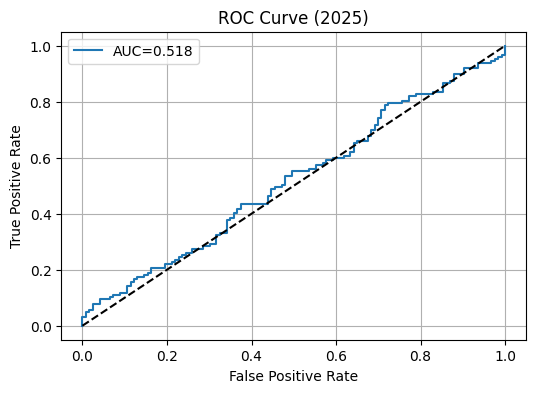

In [6]:
# === PLOTS (ROC) ===
fpr, tpr, _ = roc_curve(gts, preds)
roc_a = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_a:.3f}")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2025)")
plt.legend()
plt.grid(True)
plt.show()